In [ ]:
!git clone https://github.com/nealgravindra/scGAT.git

Cloning into 'scGAT'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 21 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), 2.95 MiB | 11.36 MiB/s, done.


In [ ]:
import torch
print(torch.__version__)

2.0.0+cu118


In [ ]:
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 18.4 MB/s eta 0:00:00


In [ ]:
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909897 sha256=91ee60fcb74c1178d036794ca7e6c2b11cda02124bfb3a84a09ca4f4c6c3647c
  Stored in directory: /root/.cache/pip/wheels/cd/7d/6b/17150450b80b4a3656a84330e22709ccd8dc0f8f4773ba4133
Successfully built torch-geometric


In [ ]:
!gdown 1VC4YMeGKEhe2u2ULvCd0GyfVl3Oz7R4G
!gdown 19JupDoL29HfGdf3E-TQZLPVyVUYhMm7r
!gdown 1C-CvSJDmsJUSWt4VGKvC3rletxPLWOAj

Downloading...
From: https://drive.google.com/uc?id=1VC4YMeGKEhe2u2ULvCd0GyfVl3Oz7R4G
To: /content/bTBI_ns_induction_test.pkl
100% 28.3M/28.3M [00:00<00:00, 92.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=19JupDoL29HfGdf3E-TQZLPVyVUYhMm7r
To: /content/bTBI_ns_induction_train.pkl
100% 28.3M/28.3M [00:00<00:00, 138MB/s]
Downloading...
From: https://drive.google.com/uc?id=1C-CvSJDmsJUSWt4VGKvC3rletxPLWOAj
To: /content/bTBI_ns_induction_val.pkl
100% 28.3M/28.3M [00:00<00:00, 121MB/s]


In [ ]:
def scipysparse2torchsparse(x) :
    '''
    Input: scipy csr_matrix
    Returns: torch tensor in experimental sparse format

    REF: Code adatped from [PyTorch discussion forum](https://discuss.pytorch.org/t/better-way-to-forward-sparse-matrix/21915>)
    '''
    samples=x.shape[0]
    features=x.shape[1]
    values=x.data
    coo_data=x.tocoo()
    #indices=torch.LongTensor([coo_data.row,coo_data.col]) # OR transpose list of index tuples
    indices_array = np.array([coo_data.row, coo_data.col], dtype=np.int64)
    indices = torch.from_numpy(indices_array)
    t=torch.sparse.FloatTensor(indices,torch.from_numpy(values).float(),[samples,features])
    return indices,t

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.gat1 = GATConv(d.num_node_features, out_channels=nHiddenUnits,
                            heads=nHeads, concat=True, negative_slope=alpha,
                            dropout=dropout, bias=True)
        self.gat2 = GATConv(nHiddenUnits*nHeads, d.y.unique().size()[0],
                            heads=nHeads, concat=False, negative_slope=alpha,
                            dropout=dropout, bias=True)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
import os,sys,pickle,time,random,glob
import numpy as np
import pandas as pd

from typing import List
import copy
import os.path as osp
import torch
import torch.utils.data
from torch_sparse import SparseTensor, cat
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv

pdfp = r'/content/'
data_train_pkl = 'bTBI_ns_induction_train.pkl'
data_val_pkl = 'bTBI_ns_induction_val.pkl'
data_test_pkl = 'bTBI_ns_induction_test.pkl'
replicate='0' # for pkl file saved

BatchSize = 256*4
NumParts = 10000 # num sub-graphs
Device = 'cuda' # if no gpu, `Device='cpu'`
LR = 0.01 # learning rate
WeightDecay=5e-5
fastmode = False # if `fastmode=False`, report validation
nHiddenUnits = 64
nHeads = 64 # number of attention heads
nEpochs = 5000
dropout = 0.4 # applied to all GAT layers
alpha = 0.2 # alpha for leaky_relu
patience = 500 # epochs to beat
clip = 1 # set `clip=1` to turn on gradient clipping
rs=random.randint(1,1000000) # random_seed

with open(os.path.join(pdfp,data_test_pkl),'rb') as f :
    datapkl = pickle.load(f)
    f.close()

node_features = torch.from_numpy(datapkl['features'].todense()).float()
# _,node_features = scipysparse2torchsparse(features)
labels = torch.LongTensor(datapkl['labels'])
edge_index,_ = scipysparse2torchsparse(datapkl['adj'])
del datapkl

d = Data(x=node_features, edge_index=edge_index, y=labels)
del node_features,edge_index,labels

In [ ]:
import seaborn as sns

In [ ]:
device = torch.device(Device)
model = GAT().to(device)
model.load_state_dict(torch.load(r'/content/4994-0.pkl'))

model.eval()
d_test = d.to(device)
h_prime = model(d_test)

In [ ]:
def load_pkl(fname):
    with open(fname, 'rb') as f:
        data = pickle.load(f)
        f.close()
    return data

In [ ]:
featnames = load_pkl('/content/genies.pkl')
n_heads = nHeads
n_top = 1
g_idx = []
n_hidden_units = nHiddenUnits
print(n_heads, n_hidden_units)
weight_per_headz = model.gat1.state_dict()['lin_src.weight'].detach().cpu().numpy().T.reshape(2000,nHeads,nHiddenUnits, order='F')
print(weight_per_headz.shape)
for i in range(n_heads):
    [g_idx.append(i) for i in np.max(np.abs(weight_per_headz[:,:,i]),axis=1).argsort()[-n_top:]]
g_idx = np.unique(g_idx)
w_top = np.zeros([g_idx.shape[0],n_hidden_units,n_heads])
for i in range(n_heads):
    w_top[:,:,i] = weight_per_headz[g_idx,:,i]
w_top= w_top.reshape((w_top.shape[0],-1))
w_top = pd.DataFrame(w_top, index=[g for i,g in enumerate(featnames) if i in g_idx])

64 64
(2000, 64, 64)


In [ ]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.9/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


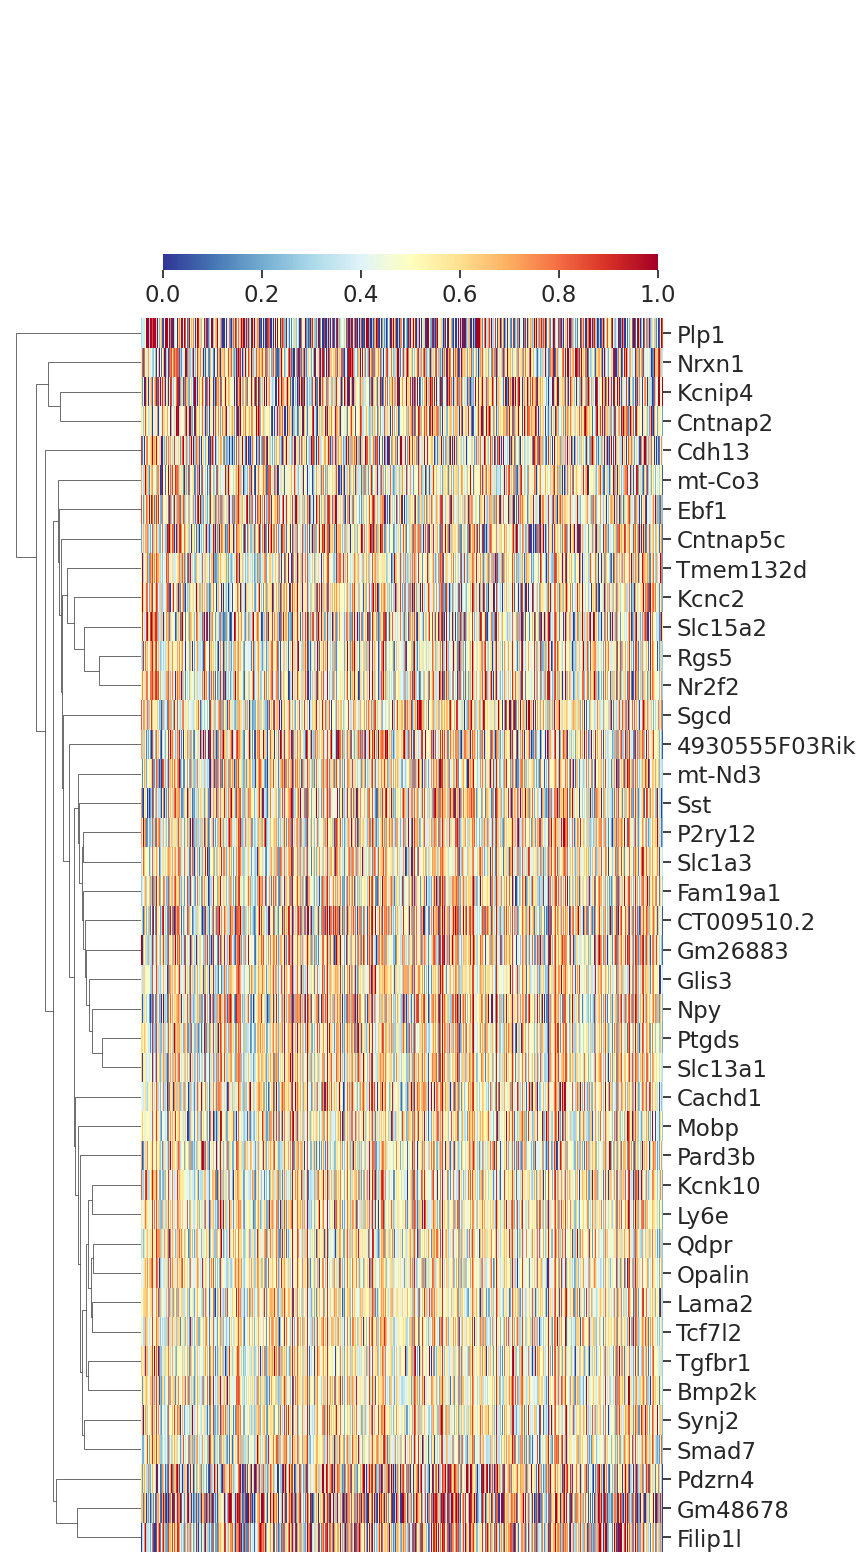

In [ ]:
sns.set(font_scale=1.5)
sns.clustermap(
    w_top,
    pivot_kws=None,
    method='average',
    metric='euclidean',
    z_score=None,
    standard_scale=1,
    figsize=(9,16),
    cbar_kws={'orientation': 'horizontal'},
    row_cluster=True,
    col_cluster=None,
    row_linkage=None,
    col_linkage=None,
    row_colors=None,
    col_colors=None,
    mask=None,
    cmap='RdYlBu_r',
    yticklabels=True,
    xticklabels=False,
    cbar_pos=[0.2, .82, 0.55, 0.01], 
)

In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=5e980e816187bd16fd5082bd33beed7b46066892d8dfbad3e0383a0836608f4b
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55640 sha256=87d5f8b4d8cc00b3bab7d39384ed629c9a3e5147984c2e698d5b3628906493b9
  Stored in directory: /root/.cache/pip/wheels/12/f9/4d/ec5ad1c823c710fcc4473669fdcffc8891f4bc398c841af22e
Successfully built umap-learn pynndescent


In [ ]:
import umap
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
h_prime = h_prime.detach().cpu().numpy()

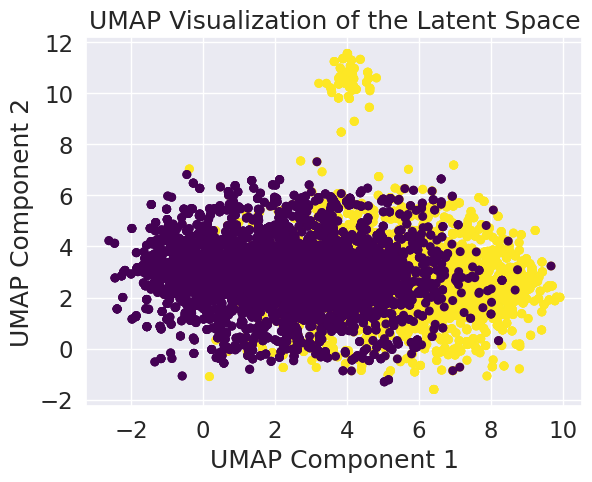

In [ ]:
reducer = umap.UMAP(n_neighbors=2, n_components=10, metric='chebyshev')
h_prime_2d = reducer.fit_transform(h_prime)

# Plot the 2D representation
plt.scatter(h_prime_2d[:, 0], h_prime_2d[:, 1], c=d.y.cpu(), cmap='viridis', marker='o', s=30)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Visualization of the Latent Space')
# plt.colorbar()
plt.show()

In [ ]:
import matplotlib.patches as mpatches

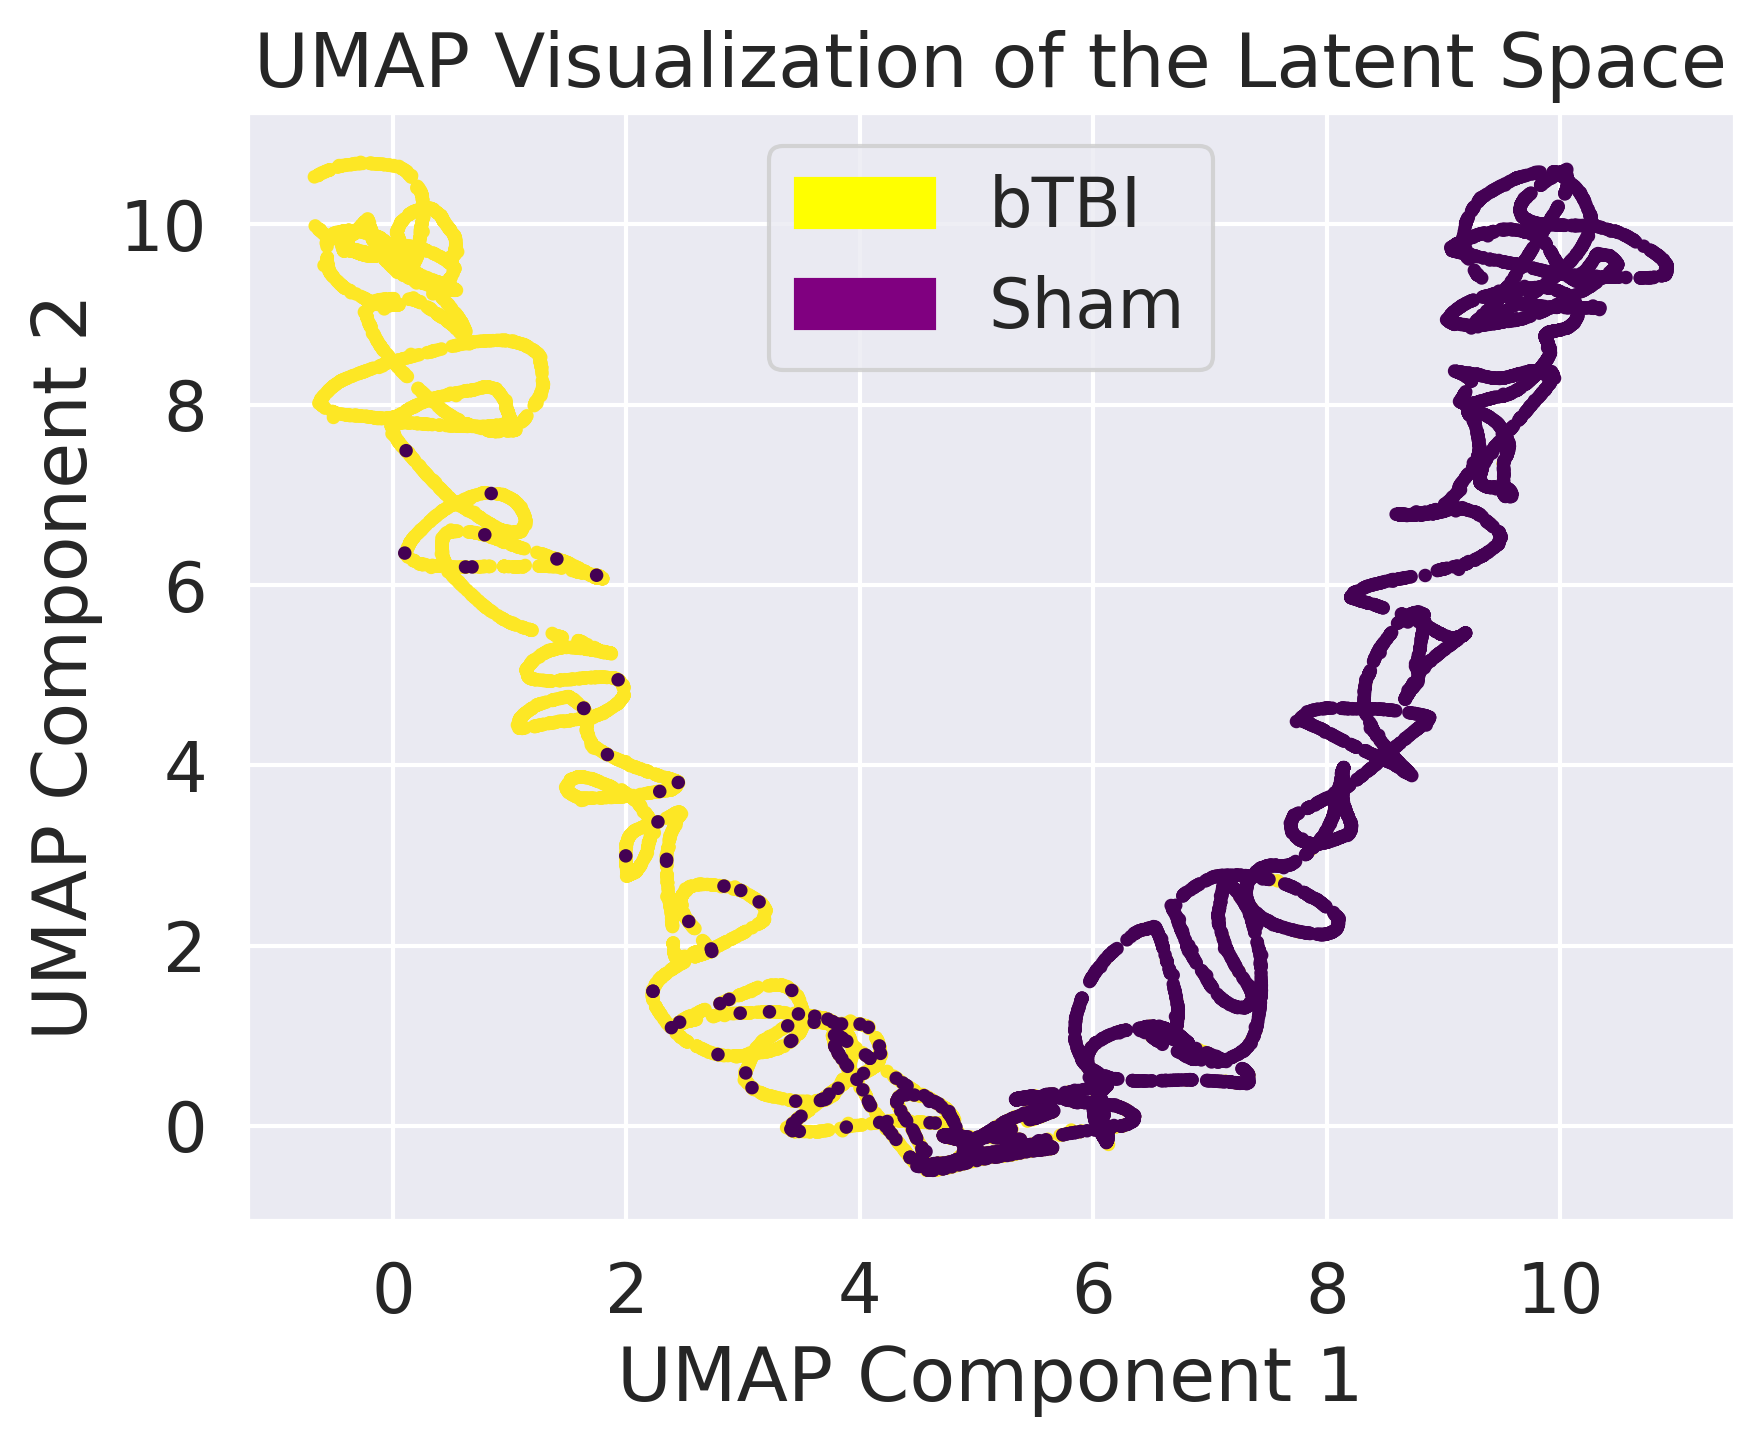

In [ ]:
fig, ax = plt.subplots(dpi=300)
scatter = ax.scatter(h_prime_2d[:, 0], h_prime_2d[:, 1], cmap='viridis', c=d.y.cpu()[:], marker='.', s=20)
yellow_patch = mpatches.Patch(color='yellow', label='bTBI')
purple_patch = mpatches.Patch(color='purple', label='Sham')
ax.legend(handles=[yellow_patch, purple_patch])
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_title('UMAP Visualization of the Latent Space')
plt.show()

In [ ]:
'''
ind1.py

Stochasticitity for ACM CHIL 2020 paper
Neal G. Ravindra, 200228
'''

import os,sys,pickle,time,random,glob
import numpy as np
import pandas as pd

from typing import List
import copy
import os.path as osp
import torch
import torch.utils.data
from torch_sparse import SparseTensor, cat
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv


## utils
def scipysparse2torchsparse(x) :
    '''
    Input: scipy csr_matrix
    Returns: torch tensor in experimental sparse format

    REF: Code adatped from [PyTorch discussion forum](https://discuss.pytorch.org/t/better-way-to-forward-sparse-matrix/21915>)
    '''
    samples=x.shape[0]
    features=x.shape[1]
    values=x.data
    coo_data=x.tocoo()
    #indices=torch.LongTensor([coo_data.row,coo_data.col]) # OR transpose list of index tuples
    indices_array = np.array([coo_data.row, coo_data.col], dtype=np.int64)
    indices = torch.from_numpy(indices_array)
    t=torch.sparse.FloatTensor(indices,torch.from_numpy(values).float(),[samples,features])
    return indices,t

def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

## load data
class ClusterData(torch.utils.data.Dataset):
    r"""Clusters/partitions a graph data object into multiple subgraphs, as
    motivated by the `"Cluster-GCN: An Efficient Algorithm for Training Deep
    and Large Graph Convolutional Networks"
    <https://arxiv.org/abs/1905.07953>`_ paper.

    Args:
        data (torch_geometric.data.Data): The graph data object.
        num_parts (int): The number of partitions.
        recursive (bool, optional): If set to :obj:`True`, will use multilevel
            recursive bisection instead of multilevel k-way partitioning.
            (default: :obj:`False`)
        save_dir (string, optional): If set, will save the partitioned data to
            the :obj:`save_dir` directory for faster re-use.
    """
    def __init__(self, data, num_parts, recursive=False, save_dir=None):
        assert (data.edge_index is not None)

        self.num_parts = num_parts
        self.recursive = recursive
        self.save_dir = save_dir

        self.process(data)

    def process(self, data):
        recursive = '_recursive' if self.recursive else ''
        filename = f'part_data_{self.num_parts}{recursive}.pt'

        path = osp.join(self.save_dir or '', filename)
        if self.save_dir is not None and osp.exists(path):
            data, partptr, perm = torch.load(path)
        else:
            data = copy.copy(data)
            num_nodes = data.num_nodes

            (row, col), edge_attr = data.edge_index, data.edge_attr
            adj = SparseTensor(row=row, col=col, value=edge_attr)
            adj, partptr, perm = adj.partition(self.num_parts, self.recursive)

            for key, item in data:
                if item.size(0) == num_nodes:
                    data[key] = item[perm]

            data.edge_index = None
            data.edge_attr = None
            data.adj = adj

            if self.save_dir is not None:
                torch.save((data, partptr, perm), path)

        self.data = data
        self.perm = perm
        self.partptr = partptr


    def __len__(self):
        return self.partptr.numel() - 1


    def __getitem__(self, idx):
        start = int(self.partptr[idx])
        length = int(self.partptr[idx + 1]) - start

        data = copy.copy(self.data)
        num_nodes = data.num_nodes

        for key, item in data:
            if item.size(0) == num_nodes:
                data[key] = item.narrow(0, start, length)

        data.adj = data.adj.narrow(1, start, length)

        row, col, value = data.adj.coo()
        data.adj = None
        data.edge_index = torch.stack([row, col], dim=0)
        data.edge_attr = value

        return data


    def __repr__(self):
        return (f'{self.__class__.__name__}({self.data}, '
                f'num_parts={self.num_parts})')



class ClusterLoader(torch.utils.data.DataLoader):
    r"""The data loader scheme from the `"Cluster-GCN: An Efficient Algorithm
    for Training Deep and Large Graph Convolutional Networks"
    <https://arxiv.org/abs/1905.07953>`_ paper which merges partioned subgraphs
    and their between-cluster links from a large-scale graph data object to
    form a mini-batch.

    Args:
        cluster_data (torch_geometric.data.ClusterData): The already
            partioned data object.
        batch_size (int, optional): How many samples per batch to load.
            (default: :obj:`1`)
        shuffle (bool, optional): If set to :obj:`True`, the data will be
            reshuffled at every epoch. (default: :obj:`False`)
    """
    def __init__(self, cluster_data, batch_size=1, shuffle=False, **kwargs):
        class HelperDataset(torch.utils.data.Dataset):
            def __len__(self):
                return len(cluster_data)

            def __getitem__(self, idx):
                start = int(cluster_data.partptr[idx])
                length = int(cluster_data.partptr[idx + 1]) - start

                data = copy.copy(cluster_data.data)
                num_nodes = data.num_nodes
                for key, item in data:
                    if item.size(0) == num_nodes:
                        data[key] = item.narrow(0, start, length)

                return data, idx

        def collate(batch):
            data_list = [data[0] for data in batch]
            parts: List[int] = [data[1] for data in batch]
            partptr = cluster_data.partptr

            adj = cat([data.adj for data in data_list], dim=0)

            adj = adj.t()
            adjs = []
            for part in parts:
                start = partptr[part]
                length = partptr[part + 1] - start
                adjs.append(adj.narrow(0, start, length))
            adj = cat(adjs, dim=0).t()
            row, col, value = adj.coo()

            data = cluster_data.data.__class__()
            data.num_nodes = adj.size(0)
            data.edge_index = torch.stack([row, col], dim=0)
            data.edge_attr = value

            ref = data_list[0]
            keys = ref.keys
            keys.remove('adj')

            for key in keys:
                if ref[key].size(0) != ref.adj.size(0):
                    data[key] = ref[key]
                else:
                    data[key] = torch.cat([d[key] for d in data_list],
                                          dim=ref.__cat_dim__(key, ref[key]))

            return data

        super(ClusterLoader,
              self).__init__(HelperDataset(), batch_size, shuffle,
                             collate_fn=collate, **kwargs)

################################################################################
# hyperparams
################################################################################
pdfp = r'/content/'
data_train_pkl = 'bTBI_ns_induction_train.pkl'
data_val_pkl = 'bTBI_ns_induction_val.pkl'
data_test_pkl = 'bTBI_ns_induction_test.pkl'
replicate='0' # for pkl file saved

BatchSize = 256*4
NumParts = 10000 # num sub-graphs
Device = 'cuda' # if no gpu, `Device='cpu'`
LR = 0.01 # learning rate
WeightDecay=5e-5
fastmode = False # if `fastmode=False`, report validation
nHiddenUnits = 64
nHeads = 64 # number of attention heads
nEpochs = 5000
dropout = 0.4 # applied to all GAT layers
alpha = 0.2 # alpha for leaky_relu
patience = 500 # epochs to beat
clip = 1 # set `clip=1` to turn on gradient clipping
rs=random.randint(1,1000000) # random_seed
################################################################################

## data
with open(os.path.join(pdfp,data_train_pkl),'rb') as f :
    datapkl = pickle.load(f)
    f.close()

node_features = torch.from_numpy(datapkl['features'].todense()).float()
# _,node_features = scipysparse2torchsparse(features)
labels = torch.LongTensor(datapkl['labels'])
edge_index,_ = scipysparse2torchsparse(datapkl['adj'])
del datapkl

d = Data(x=node_features, edge_index=edge_index, y=labels)
del node_features,edge_index,labels

cd = ClusterData(d,num_parts=NumParts)
cl = ClusterLoader(cd,batch_size=BatchSize,shuffle=True)

if not fastmode :
    with open(os.path.join(pdfp,data_val_pkl),'rb') as f :
        datapkl = pickle.load(f)
        f.close()

    features_val = torch.from_numpy(datapkl['features'].todense()).float()
    labels_val = torch.LongTensor(datapkl['labels'])
    edge_index_val,_ = scipysparse2torchsparse(datapkl['adj'])
    del datapkl

## model
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.gat1 = GATConv(d.num_node_features, out_channels=nHiddenUnits,
                            heads=nHeads, concat=True, negative_slope=alpha,
                            dropout=dropout, bias=True)
        self.gat2 = GATConv(nHiddenUnits*nHeads, d.y.unique().size()[0],
                            heads=nHeads, concat=False, negative_slope=alpha,
                            dropout=dropout, bias=True)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return F.log_softmax(x, dim=1)


## train
if False :
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # don't let user make decisions
else :
    device = torch.device(Device)

random.seed(rs)
np.random.seed(rs)
torch.manual_seed(rs)
if Device == 'cuda' :
    torch.cuda.manual_seed(rs)

model = GAT().to(device)
optimizer = torch.optim.Adagrad(model.parameters(),
                                lr=LR,
                                weight_decay=WeightDecay)

# features, adj, labels = Variable(features), Variable(adj), Variable(labels)

def train(epoch):
    t = time.time()
    epoch_loss = []
    epoch_acc = []
    epoch_acc_val = []
    epoch_loss_val = []

    model.train()
    for batch in cl :
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        # y_true = batch.y.to(device)
        loss = F.nll_loss(output, batch.y)
        loss.backward()
        if clip is not None :
            torch.nn.utils.clip_grad_norm_(model.parameters(),clip)
        optimizer.step()
        epoch_loss.append(loss.item())
        epoch_acc.append(accuracy(output, batch.y).item())
    if not fastmode :
        d_val = Data(x=features_val,edge_index=edge_index_val,y=labels_val)
        d_val = d_val.to(device)
        model.eval()
        output = model(d_val)
        loss_val = F.nll_loss(output, d_val.y)
        acc_val = accuracy(output,d_val.y).item()
        print('Epoch {}\t<loss>={:.4f}\t<acc>={:.4f}\tloss_val={:.4f}\tacc_val={:.4f}\tin {:.2f}-s'.format(epoch,np.mean(epoch_loss),np.mean(epoch_acc),loss_val.item(),acc_val,time.time() - t))
        return loss_val.item()
    else :
        print('Epoch {}\t<loss>={:.4f}\t<acc>={:.4f}\tin {:.2f}-s'.format(epoch,np.mean(epoch_loss),np.mean(epoch_acc),time.time()-t))
        return np.mean(epoch_loss)


def compute_test():
    with open(os.path.join(pdfp,data_test_pkl),'rb') as f :
        datapkl = pickle.load(f)
        f.close()

    features_test = torch.from_numpy(datapkl['features'].todense()).float()
    labels_test = torch.LongTensor(datapkl['labels'])
    edge_index_test,_ = scipysparse2torchsparse(datapkl['adj'])
    del datapkl

    d_test = Data(x=features_test,edge_index=edge_index_test,y=labels_test)
    del features_test,edge_index_test,labels_test

    model.eval()
    d_test=d_test.to(device)
    output = model(d_test)
    loss_test = F.nll_loss(output, d_test.y)
#     loss_test = nn.BCEWithLogitsLoss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output, d_test.y).item()
    print("Test set results:",
          "\n    loss={:.4f}".format(loss_test.item()),
          "\n    accuracy={:.4f}".format(acc_test))

## call trainer
t_total = time.time()
loss_values = []
bad_counter = 0
best = nEpochs + 1
best_epoch = 0

model.load_state_dict(torch.load(r'/content/1960-0.pkl'))

for epoch in range(nEpochs):
    loss_values.append(train(epoch))

    torch.save(model.state_dict(), '{}-'.format(epoch)+replicate+'.pkl')
    if loss_values[-1] < best:
        best = loss_values[-1]
        best_epoch = epoch
        bad_counter = 0
    else:
        bad_counter += 1

    if bad_counter == patience:
        break

    files = glob.glob('*-'+replicate+'.pkl')
    for file in files:
        epoch_nb = int(file.split('-'+replicate+'.pkl')[0])
        if epoch_nb < best_epoch:
            os.remove(file)

files = glob.glob('*-'+replicate+'.pkl')
for file in files:
    epoch_nb = int(file.split('-'+replicate+'.pkl')[0])
    if epoch_nb > best_epoch:
        os.remove(file)

print('Optimization Finished!')
print('Total time elapsed: {:.2f}-min'.format((time.time() - t_total)/60))

# Restore best model
print('Loading epoch #{}'.format(best_epoch))
model.load_state_dict(torch.load('{}-'.format(best_epoch)+replicate+'.pkl'))

# Testing
compute_test()
